In [1]:
import os
import random
import torch
import time
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from PIL import Image

from generative.networks.nets import DiffusionModelUNet
import wandb
from matplotlib import pyplot as plt
from tqdm import trange, tqdm
import numpy as np
import pandas as pd

from skimage.metrics import structural_similarity as ssim_fn
from skimage.metrics import peak_signal_noise_ratio as psnr_fn

/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/andrea_moschetto/miniconda3/envs/medical/lib/python3.11/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [2]:
DATAPATH = '/home/andrea_moschetto/FlowMatching-MREConversion/data'
OUTPUT_DIR = "/home/andrea_moschetto/FlowMatching-MREConversion/outputs"
CHECKPOINTS_PATH = '/home/andrea_moschetto/FlowMatching-MREConversion/checkpoints'

In [3]:
class UnifiedBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None, split="train", seed=42):
        assert split in ["train", "val",
                         "test"], "split must be 'train', 'val' or 'test'"
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.seed = seed
        self.samples = self._create_file_pairs()
        self._split_dataset()

    def _create_file_pairs(self):
        t1_dir = os.path.join(self.root_dir, "t1")
        t2_dir = os.path.join(self.root_dir, "t2")

        t1_files = set(os.listdir(t1_dir))
        t2_files = set(os.listdir(t2_dir))
        common_files = list(t1_files.intersection(t2_files))
        common_files.sort()

        pairs = [(os.path.join(t1_dir, fname), os.path.join(t2_dir, fname))
                 for fname in common_files]
        return pairs

    def _split_dataset(self):
        random.seed(self.seed)
        random.shuffle(self.samples)

        n_total = len(self.samples)
        n_train = int(n_total * 0.80)
        n_val = int(n_total * 0.05)
        n_test = n_total - n_train - n_val

        if self.split == "train":
            self.samples = self.samples[:n_train]
        elif self.split == "val":
            self.samples = self.samples[n_train:n_train + n_val]
        elif self.split == "test":
            self.samples = self.samples[n_train + n_val:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t1_path, t2_path = self.samples[idx]
        t1_image = Image.open(t1_path).convert("L")
        t2_image = Image.open(t2_path).convert("L")

        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)

        return {
            "t1": t1_image,
            "t2": t2_image,
            "filename": os.path.basename(t1_path)
        }

In [4]:
def euler_step(model: DiffusionModelUNet, x_t: Tensor, t_start: Tensor, t_end: Tensor):
    # delta_t shape (B, 1, 1, 1)
    delta_t = (t_end - t_start).view(-1, 1, 1, 1)

    # model si aspetta t come tensor (B,)
    v_hat = model(x_t, t_start)

    x_next = x_t + delta_t * v_hat

    return x_next


@torch.no_grad()
def generate(model: nn.Module, x_T: Tensor, n_steps: int = 20):
    model.eval()

    device = x_T.device
    batch_size = x_T.shape[0]

    time_steps = torch.linspace(
        0.0, 1.0, n_steps + 1, device=device, dtype=torch.float32)

    x = x_T
    for i in range(n_steps):
        t_start = time_steps[i].expand(batch_size)
        t_end = time_steps[i + 1].expand(batch_size)
        x = euler_step(model, x_t=x, t_start=t_start, t_end=t_end)

    return x

In [5]:
def percnorm(arr, lperc=5, uperc=99.5):
    """
    Remove outlier intensities from a brain component,
    similar to Tukey's fences method.
    """
    upperbound = np.percentile(arr, uperc)
    lowerbound = np.percentile(arr, lperc)
    arr[arr > upperbound] = upperbound
    arr[arr < lowerbound] = lowerbound
    return arr


def normalize(img):
    # img: [C, H, W]
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img


def preprocess_image(in_tensor_img):
    # tensor_img: [1, H, W]
    img_np = in_tensor_img.squeeze(0).cpu().numpy()  # [H, W]
    # Percentile-based normalization
    img_np = percnorm(img_np)
    out_tensor_image = torch.from_numpy(
        img_np).unsqueeze(0)  # Back to [1, H, W]
    out_tensor_image = normalize(
        out_tensor_image)            # 0-1 normalization
    return out_tensor_image.to(in_tensor_img.device) 

In [6]:
def log_generation(model, epoch, device, n_steps: int, reference_image=None, use_wandb=True):
    with torch.no_grad():
        if reference_image is not None:
            reference_t1, reference_t2 = reference_image  # t1 = input, t2 = ground truth
            # input al modello = t1
            x_T = reference_t1.to(device)
            x_gen = generate(model=model, x_T=x_T, n_steps=n_steps)

            # Visualizza t1 (input), t2 (vero), x_gen (generato)
            images = torch.cat([reference_t1, reference_t2,
                               x_gen], dim=0)  # [3, 1, H, W]

        else:
            raise ValueError(
                "reference_image must be provided when generating from t1.")

        grid = torchvision.utils.make_grid(images, nrow=3, normalize=True)

        if use_wandb:
            wandb.log({
                "generation": [wandb.Image(grid, caption=f"Epoch {epoch+1}")]
            })

        return grid, x_gen


def show_grid(grid):
    # grid è un tensore [C, H, W], lo trasformiamo in un'immagine visualizzabile
    np_grid = grid.permute(1, 2, 0).cpu().numpy()  # da [C,H,W] a [H,W,C]
    plt.figure(figsize=(8, 8))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.show()

In [7]:
if not os.path.exists(f'{CHECKPOINTS_PATH}/backups'):
    os.makedirs(f'{CHECKPOINTS_PATH}/backups')


def train_flow(model: DiffusionModelUNet, train_loader: DataLoader, val_loader: DataLoader, project: str, exp_name: str, notes: str, n_epochs: int = 10, lr: float = 1e-3, generation_steps: int = 100):
    with wandb.init(
        project=project,
        name=exp_name,
        notes=notes,
        tags=["flow", "brain", "diffusion"],
        config={
            'model': model.__class__.__name__,
            'epochs': n_epochs,
            'batch_size': train_loader.batch_size,
            'num_workers': train_loader.num_workers,
            'optimizer': 'Adam',
            'learning_rate': lr,
            'loss_function': 'MSELoss',
            'generation_steps': generation_steps,
            'device': str(torch.cuda.get_device_name(0)
                          if torch.cuda.is_available() else "CPU"),
        }
    ) as run:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.get_device_name(0)
              if torch.cuda.is_available() else "CPU")

        model.to(device)
        model.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-6)

        best_val_loss = float("inf")
        best_model_path = None
        start_time = time.time()
        for e in trange(n_epochs, desc="Epochs"):
            start_e_time = time.time()
            # Training
            model.train()
            train_losses = []
            for batch in train_loader:
                x_1 = batch["t2"].to(device)  # [B, 1, H, W]
                # [B, 1, H, W]  # torch.randn_like(x_1).to(device)  # [B, 1, H, W]
                x_0 = batch["t1"].to(device)
                # add the corresponding t1 to the second channel of x_0

                B = x_0.shape[0]
                t = torch.rand(B, device=device)  # B

                t_img = t.view(B, 1, 1, 1)  # [B, 1, 1, 1] for broadcasting

                x_t = (1 - t_img) * x_0 + t_img * x_1         # [B, 1, H, W]
                dx_t = x_1 - x_0                              # [B, 1, H, W]

                optimizer.zero_grad()
                pred = model(x_t, t)  # [B, 1, H, W]
                loss = criterion(pred, dx_t)
                train_losses.append(loss.item())
                loss.backward()
                optimizer.step()
            wandb.log({"train_loss": sum(train_losses) / len(train_losses)})
            wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})

            # Validation
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    x_1 = batch["t2"].to(device)
                    x_0 = batch["t1"].to(device)
                    B = x_0.shape[0]
                    t = torch.rand(B, device=device)
                    t_img = t.view(B, 1, 1, 1)
                    x_t = (1 - t_img) * x_0 + t_img * x_1
                    dx_t = x_1 - x_0

                    pred = model(x_t, t)
                    val_loss = criterion(pred, dx_t)
                    val_losses.append(val_loss.item())
            batch_val_loss = sum(val_losses) / len(val_losses)
            wandb.log({"val_loss": batch_val_loss})
            e_time = time.time() - start_e_time
            wandb.log({"epoch_time_minutes": e_time // 60})

            lr_scheduler.step()
            # Checkpoint
            if e % 5 == 0 or e == n_epochs-1 or batch_val_loss < best_val_loss:
                sample_batch = next(iter(val_loader))  # just one batch
                t1_gt = sample_batch["t1"][0].unsqueeze(0).to(device)
                t2_gt = sample_batch["t2"][0].to(device)  # [1, 1, H, W]
                t2_gen = generate(model=model, x_T=t1_gt, n_steps=generation_steps)
                imgs = torch.stack([t1_gt.squeeze(0), t2_gt, preprocess_image(t2_gen.squeeze(0))], dim=0)  # [3, 1, H, W]
                grid = torchvision.utils.make_grid(imgs, nrow=3)

                if batch_val_loss < best_val_loss:
                    path = f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{e+1}_best.pth'
                    torch.save({
                        'epoch': e+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, path)
                    if best_model_path is not None and os.path.exists(best_model_path):
                        os.remove(best_model_path)
                    best_model_path = path
                    best_val_loss = batch_val_loss
                    wandb.log({
                        "best_model_generations": [wandb.Image(grid, caption=f"Epoch {e+1} - Best")]
                    })
                else:
                    path = f'{CHECKPOINTS_PATH}/backups/checkpoint_{exp_name}_{e+1}.pth'
                    torch.save({
                        'epoch': e+1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                    }, path)
                    wandb.log({
                        "each5e_generation": [wandb.Image(grid, caption=f"Epoch {e+1}")]
                    })
                
                
        end_time = time.time()
        elapsed_time = end_time - start_time
        wandb.log({"total_running_hours": elapsed_time // 3600})
        print(
            f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")
    print("Training complete.")
    return best_model_path

In [8]:
@torch.no_grad()
def generate_and_save_predictions(model, test_loader, device, output_dir=OUTPUT_DIR):
    os.makedirs(output_dir, exist_ok=True)
    model.eval()

    all_outputs = []

    for batch in tqdm(test_loader, desc="Generating Predictions"):
        t1 = batch["t1"].to(device)           # [B, 1, H, W]
        t2 = batch["t2"].to(device)           # [B, 1, H, W]
        filenames = batch["filename"]         # list of strings (length B)

        x_gen = generate(model, x_T=t1, n_steps=300)
        # print(t2.shape, x_gen.shape)

        for i in range(t1.size(0)):
            sample = {
                "filename": filenames[i],
                "input": t1[i].cpu(),         # torch.Tensor [1, H, W]
                "target": t2[i].cpu(),
                "prediction": x_gen[i].cpu()
            }

            torch.save(sample, os.path.join(output_dir, f"{filenames[i]}.pt"))
            all_outputs.append(sample)

    return all_outputs

In [9]:
class PredictionDataset(Dataset):
    def __init__(self, directory):
        super().__init__()
        self.directory = directory
        self.files = sorted([
            f for f in os.listdir(directory) if f.endswith('.pt')
        ])
        if not self.files:
            raise ValueError(f"No .pt files found in directory: {directory}")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.files[idx])
        data = torch.load(file_path)
        # expected shape: [1, H, W] or [C, H, W]
        pred = data["prediction"]
        gt = data["target"]
        return pred, gt

In [10]:
from skimage import filters


def compute_ssim_from_dataset(dataset):
    ssim_scores = []
    mse_scores = []
    ssim_masked_scores = []
    psnr_scores = []

    example_pred = None
    example_gt = None

    for i in range(len(dataset)):
        pred, gt = dataset[i]  # tensors [1, H, W]

        # Convert to numpy and squeeze channel
        pred_np = pred.squeeze().cpu().numpy()
        gt_np = gt.squeeze().cpu().numpy()

        pred_np = normalize(percnorm(pred_np))
        gt_np = normalize(percnorm(gt_np))

        threshold_triangle_gt = filters.threshold_triangle(gt_np)
        mask = gt_np > threshold_triangle_gt
        masked_gt = gt_np * mask

        threshold_triangle_pred = filters.threshold_triangle(pred_np)
        mask_pred = pred_np > threshold_triangle_pred
        masked_pred = pred_np * mask_pred

        # Compute SSIM
        ssim_masked = ssim_fn(masked_gt, masked_pred, data_range=1.0)
        ssim_masked_scores.append(ssim_masked)

        ssim_val = ssim_fn(pred_np, gt_np, data_range=1.0)
        ssim_scores.append(ssim_val)

        # Compute MSE
        mse_val = F.mse_loss(pred, gt).item()
        mse_scores.append(mse_val)
        
        # Compute PSNR on masked images
        psnr_val = psnr_fn(masked_gt, masked_pred, data_range=1.0)
        psnr_scores.append(psnr_val)
        

        # Store one example for visualization
        if i == 4 and example_pred is None:
            example_pred = masked_pred
            example_gt = masked_gt

    ssim_scores = np.array(ssim_scores)
    ssim_masked_scores = np.array(ssim_masked_scores)
    mse_scores = np.array(mse_scores)
    psnr_scores = np.array(psnr_scores)

    summary = pd.DataFrame({
        "Metric": ["SSIM", "MASKED_SSIM", "MSE", "PSNR"],
        "Mean": [ssim_scores.mean(), ssim_masked_scores.mean(), mse_scores.mean(), psnr_scores.mean()],
        "Variance": [ssim_scores.var(), ssim_masked_scores.var(), mse_scores.var(), psnr_scores.var()],
    })

    # Visualize example
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(example_gt, cmap='gray')
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(example_pred, cmap='gray')
    axs[1].set_title("Prediction")
    axs[1].axis("off")

    plt.suptitle("Example Comparison")
    plt.tight_layout()
    plt.show()

    return summary

In [13]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])

train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=6,num_workers=2, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=6,num_workers=2, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=6,num_workers=2, shuffle=False)

model = DiffusionModelUNet(
    spatial_dims=2,  #  2D
    in_channels=1,  # x
    out_channels=1  # predice delta_x_t
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_name = "unetflow-t1t2-150e"
modelpath = train_flow(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    project='flowmatching-t1-to-t2',
    exp_name=exp_name,
    notes="UNet flow model for directional diffusion from T1 to T2. 50 epochs.",
    n_epochs=150,
    lr=1e-4,
    generation_steps=300)

generate_and_save_predictions(
    model, test_loader, device, output_dir=f'{OUTPUT_DIR}/{exp_name}')
exp_name = "unetflow-t1t2-150e"
out_dataset_path = '/home/andrea_moschetto/FlowMatching-MREConversion/outputs/unetflow-t1t2-150e'
out_dataset = PredictionDataset(directory=out_dataset_path)

with wandb.init(
    project='flowmatching-t1-to-t2',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the flow model on the test set.",
):

    summary = compute_ssim_from_dataset(out_dataset)
    # log the summary table
    wandb.log({"eval/metrics": wandb.Table(dataframe=summary)})
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/ssim_masked_mean": summary["Mean"][1]})
    wandb.log({"eval/mse_mean": summary["Mean"][2]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/ssim_masked_var": summary["Variance"][1]})
    wandb.log({"eval/mse_var": summary["Variance"][2]})
summary

In [18]:
# # Load the best checkpoint
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# checkpoint_path = f'{CHECKPOINTS_PATH}/checkpoint_unetflow-t1t2-150e_149.pth'
# model.load_state_dict(torch.load(checkpoint_path, map_location=device)['model_state_dict'])
# model.eval()

/tmp/ipykernel_4059/2875938224.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


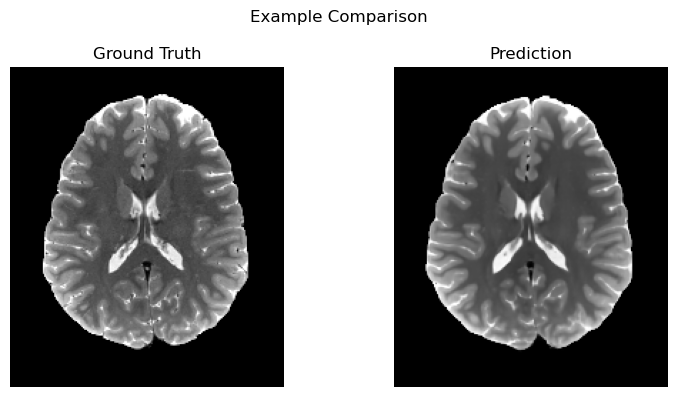

,Metric,Mean,Variance
0,SSIM,0.861851,0.000982
1,MASKED_SSIM,0.863473,0.000973
2,MSE,0.005443,0.000004
3,PSNR,22.915324,3.427676


In [25]:


out_dataset_path = '/home/andrea_moschetto/FlowMatching-MREConversion/outputs/unet2pix-t1t2-brain300e300'
out_dataset = PredictionDataset(directory=out_dataset_path)
compute_ssim_from_dataset(out_dataset)

## Comparison between FM and GAN

In [ ]:
out_dataset_path = '/home/andrea_moschetto/FlowMatching-MREConversion/outputs/unetflow-t1t2-150e'
out_dataset = PredictionDataset(directory=out_dataset_path)
sample1 = out_dataset[0]
pred = sample1[0].squeeze().cpu().numpy()
gt = sample1[1].squeeze().cpu().numpy()

pred = normalize(percnorm(pred))
gt = normalize(percnorm(gt))
ssim = ssim_fn(pred, gt, data_range=1.0)
print(f"SSIM: {ssim:.4f}")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, util

threshold_triangle_gt = filters.threshold_triangle(gt)
mask = gt > threshold_triangle_gt
masked_img = gt * mask

threshold_triangle_pred = filters.threshold_triangle(pred)
mask_pred = pred > threshold_triangle_pred
masked_pred = pred * mask_pred

ssim_masked = ssim_fn(masked_img, masked_pred, data_range=1.0)
print(f"SSIM (masked): {ssim_masked:.4f}")

SSIM (masked): 0.7523


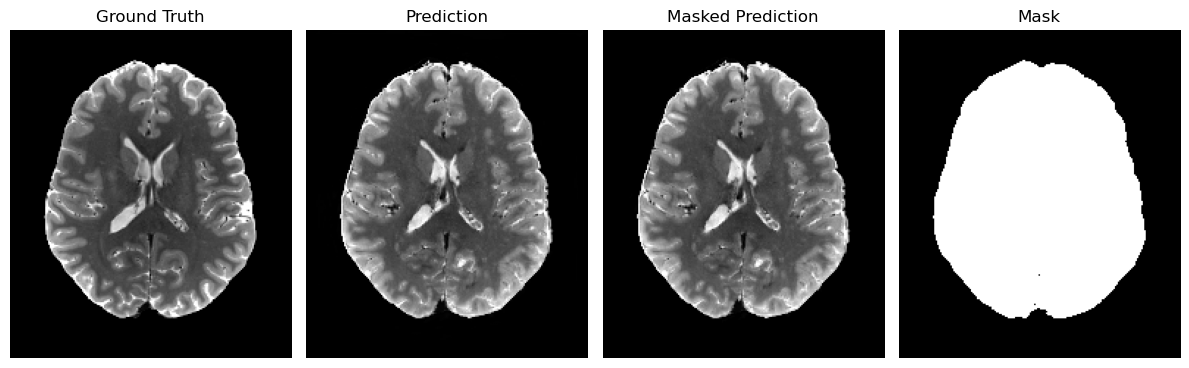

In [11]:
# compare the two images
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
axs[0].imshow(gt, cmap='gray')
axs[0].set_title("Ground Truth")
axs[0].axis("off")
axs[1].imshow(pred, cmap='gray')
axs[1].set_title("Prediction")
axs[1].axis("off")
axs[2].imshow(masked_pred, cmap='gray')
axs[2].set_title("Masked Prediction")
axs[2].axis("off")
# show the mask
axs[3].imshow(mask, cmap='gray')
axs[3].set_title("Mask")
axs[3].axis("off")
plt.tight_layout()
plt.show()

/tmp/ipykernel_1162966/1681669224.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


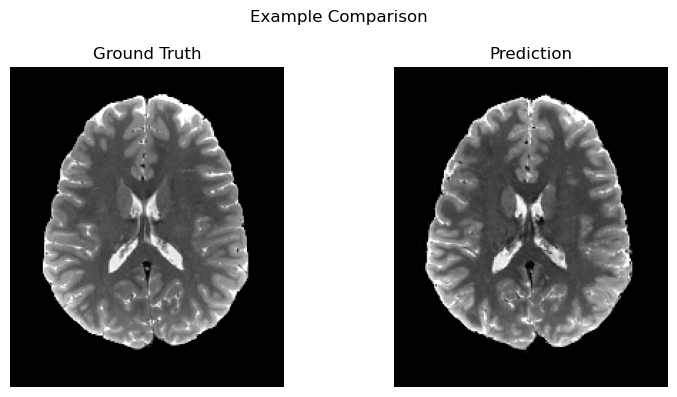

,Metric,Mean,Variance
0,SSIM,0.714118,0.001550
1,MASKED_SSIM,0.734830,0.001468
2,MSE,0.010803,0.000009


In [18]:
compute_ssim_from_dataset(out_dataset)

/tmp/ipykernel_1162966/1681669224.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


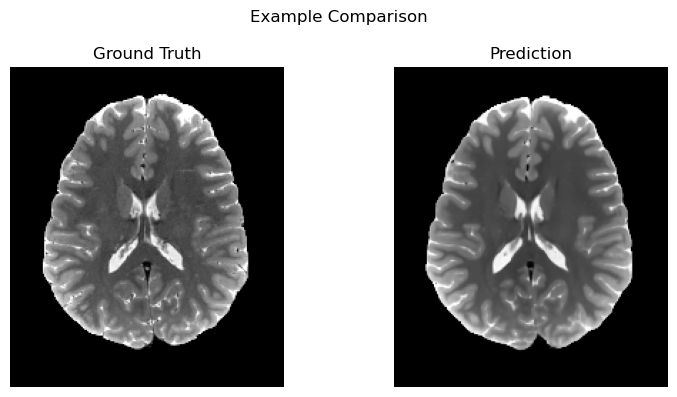

,Metric,Mean,Variance
0,SSIM,0.861851,0.000982
1,MASKED_SSIM,0.863473,0.000973
2,MSE,0.005443,0.000004


In [19]:
gan_out_dataset_path = '/home/andrea_moschetto/FlowMatching-MREConversion/outputs/unet2pix-t1t2-brain300e300'
gan_out_dataset = PredictionDataset(directory=gan_out_dataset_path)
gan_summary = compute_ssim_from_dataset(gan_out_dataset)
gan_summary

/tmp/ipykernel_1162966/1681669224.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


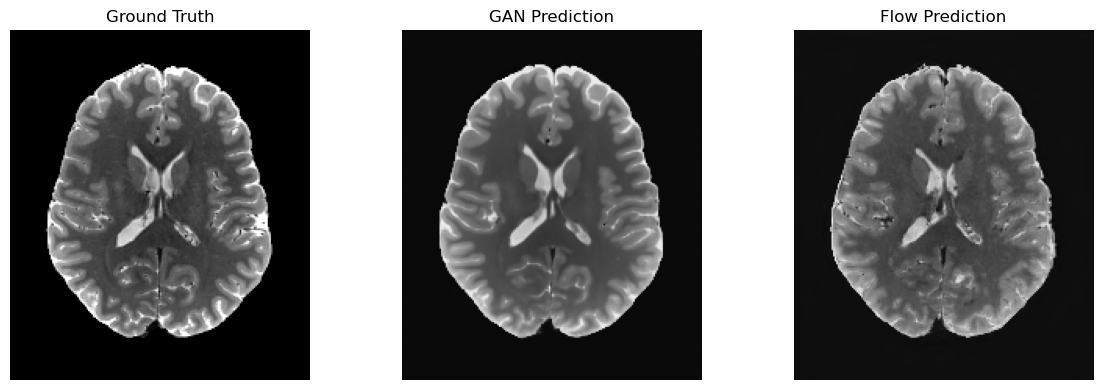

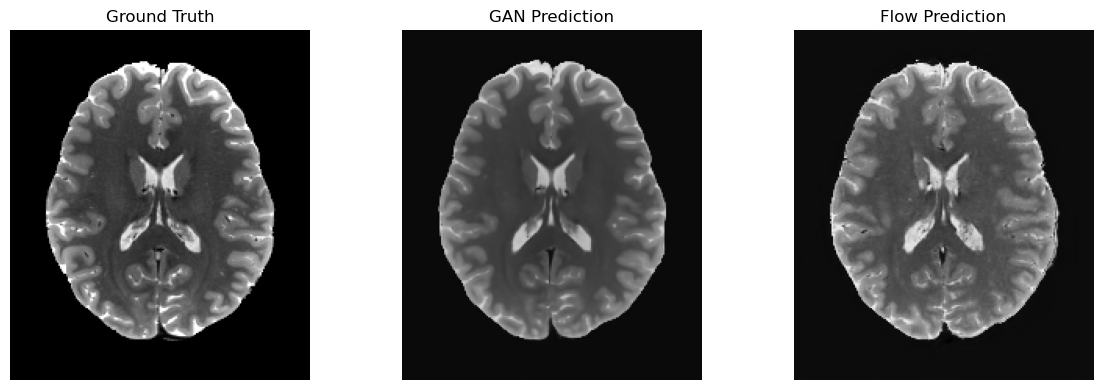

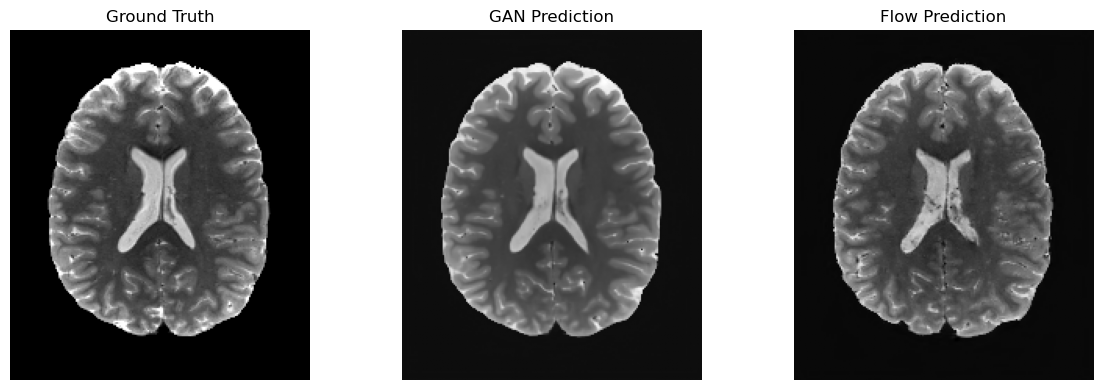

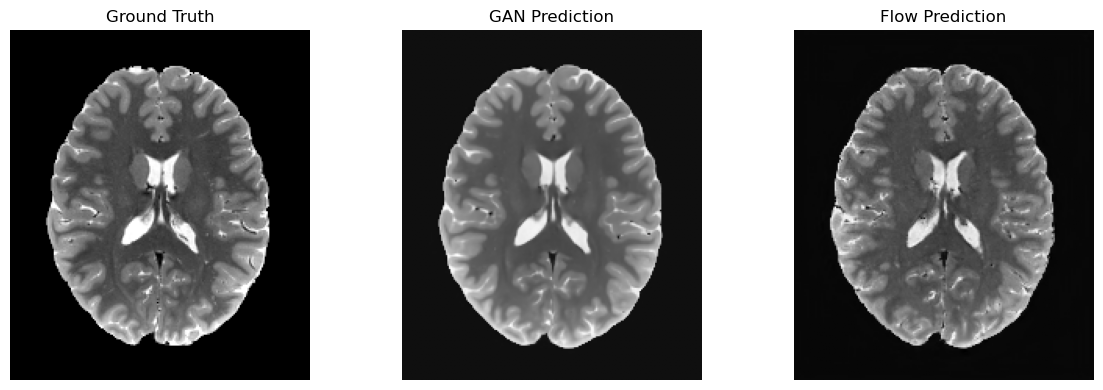

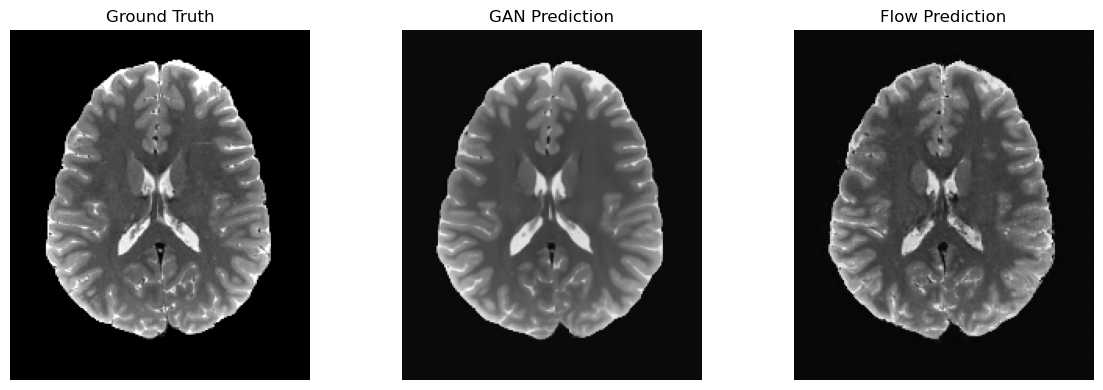

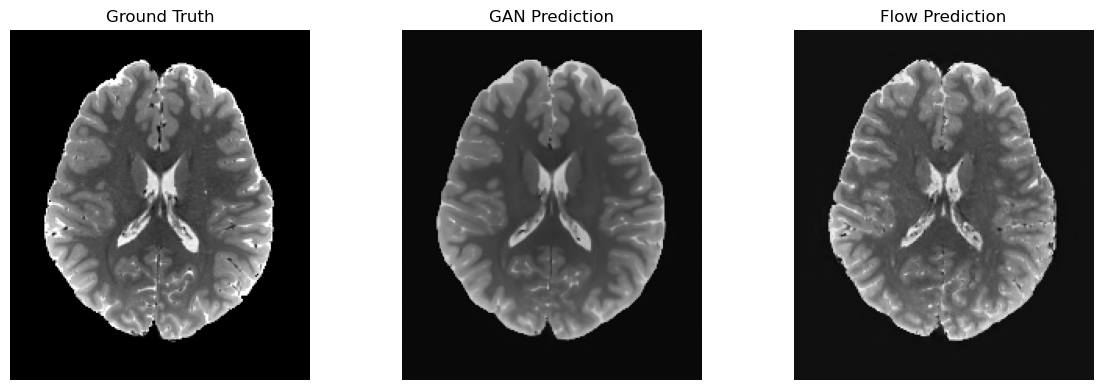

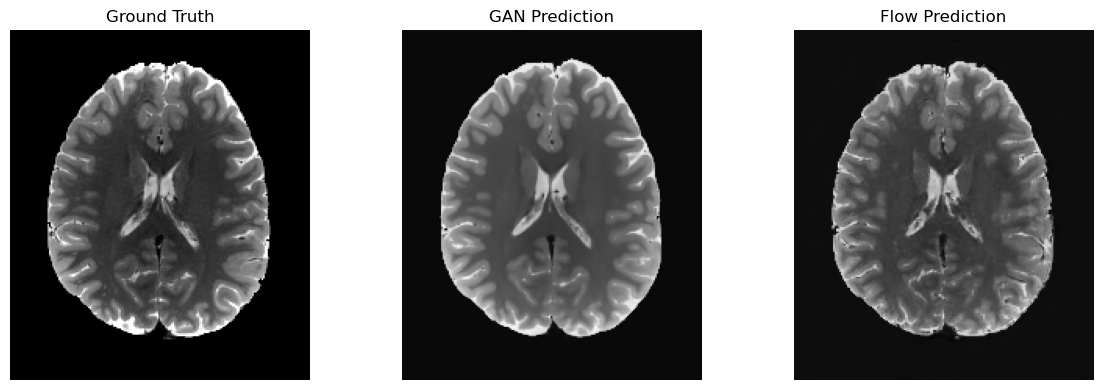

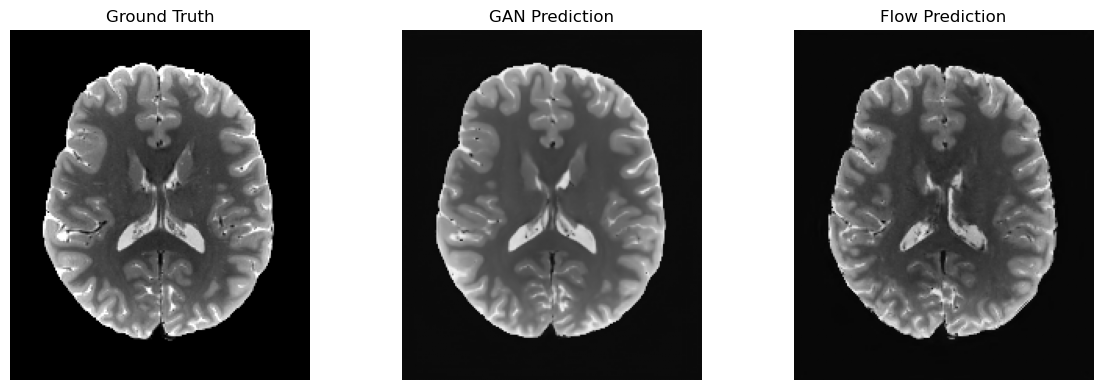

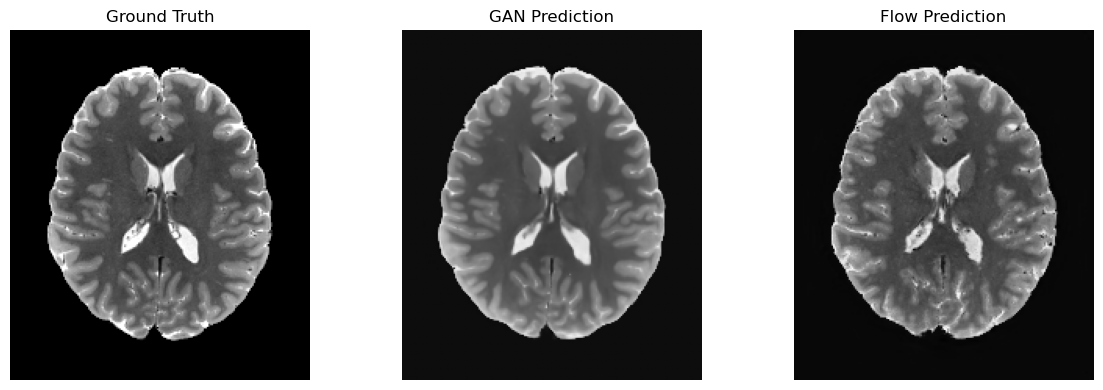

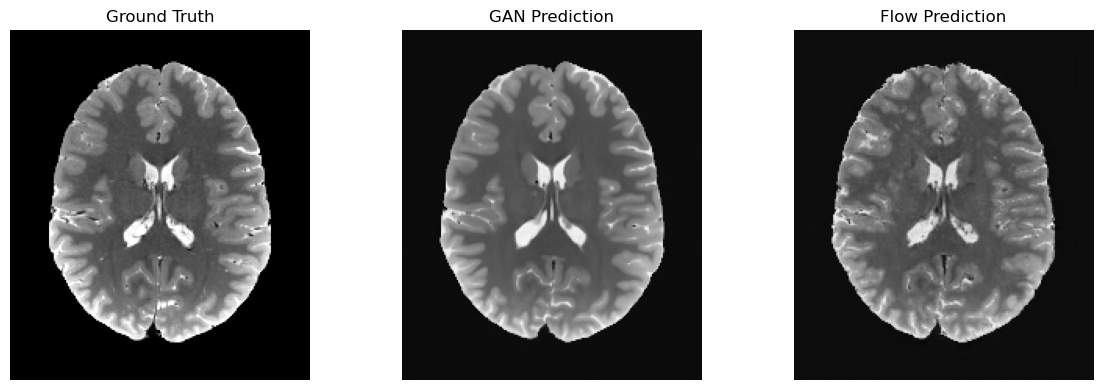

In [21]:
# comparison between the two models
# 10 predictions from each model
for i in range(10):
    gan_pred, gan_gt = gan_out_dataset[i]
    flow_pred, flow_gt = out_dataset[i]

    gan_pred_np = gan_pred.squeeze().cpu().numpy()
    flow_pred_np = flow_pred.squeeze().cpu().numpy()
    gan_gt_np = gan_gt.squeeze().cpu().numpy()
    flow_gt_np = flow_gt.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(gan_gt_np, cmap='gray')
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")

    axs[1].imshow(gan_pred_np, cmap='gray')
    axs[1].set_title("GAN Prediction")
    axs[1].axis("off")

    axs[2].imshow(flow_pred_np, cmap='gray')
    axs[2].set_title("Flow Prediction")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

## Using a bigger Unet Backbone

In [34]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])

train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=6,num_workers=2, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=6,num_workers=2, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=6,num_workers=2, shuffle=False)

model = DiffusionModelUNet(
    spatial_dims=2,  #  2D
    in_channels=1,  # x
    out_channels=1,  # predice delta_x_t
    num_channels=(64, 128, 256, 256),
    attention_levels=(False, False, True, True),
    num_head_channels=64
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_name = "big-unetflow-t1t2-300e"
best_modelpath = train_flow(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    project='flowmatching-t1-to-t2',
    exp_name=exp_name,
    notes="Big UNet flow model for directional diffusion from T1 to T2. 150 epochs.",
    n_epochs=300,
    lr=1e-4,
    generation_steps=300)

# Load the best checkpoint
model.load_state_dict(torch.load(best_modelpath, map_location=device)['model_state_dict'])
model.eval()

with wandb.init(
    project='flowmatching-t1-to-t2',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the flow model on the test set.",
):
    generate_and_save_predictions(model, test_loader, device, output_dir=f'{OUTPUT_DIR}/{exp_name}')
    out_dataset = PredictionDataset(directory=f'{OUTPUT_DIR}/{exp_name}')
    summary = compute_ssim_from_dataset(out_dataset)
    # log the summary table
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/ssim_masked_mean": summary["Mean"][1]})
    wandb.log({"eval/mse_mean": summary["Mean"][2]})
    wandb.log({"eval/psnr_mean": summary["Mean"][3]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/ssim_masked_var": summary["Variance"][1]})
    wandb.log({"eval/mse_var": summary["Variance"][2]})
    wandb.log({"eval/psnr_var": summary["Variance"][3]})
summary

wandb: Currently logged in as: andreamoschetto99 (andreamoschetto99-university-of-catania) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using Tesla T4


Epochs:   0%|▏                                                       | 1/300 [05:48<28:56:28, 348.46s/it]

## Retrain small unet with scheduler 

In [11]:
transform = transforms.Compose([
    transforms.Pad(padding=(5, 3, 5, 3), fill=0),
    transforms.ToTensor(),  # Normalize to [0, 1]
])

train_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="train")
train_loader = DataLoader(train_dataset, batch_size=6,num_workers=2, shuffle=True)
val_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="val")
val_loader = DataLoader(val_dataset, batch_size=6,num_workers=2, shuffle=False)
test_dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform, split="test")
test_loader = DataLoader(test_dataset, batch_size=6,num_workers=2, shuffle=False)

model = DiffusionModelUNet(
    spatial_dims=2,  #  2D
    in_channels=1,  # x
    out_channels=1,  # predice delta_x_t
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
exp_name = "unetflow-t1t2-s300e"
best_modelpath = train_flow(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    project='flowmatching-t1-to-t2',
    exp_name=exp_name,
    notes="Small UNet flow model for directional diffusion from T1 to T2. 300 epochs.",
    n_epochs=300,
    lr=3e-4,
    generation_steps=300)

# Load the best checkpoint
model.load_state_dict(torch.load(best_modelpath, map_location=device)['model_state_dict'])
model.eval()

with wandb.init(
    project='flowmatching-t1-to-t2',
    name=f'evaluation-{exp_name}',
    notes="Evaluation of the flow model on the test set.",
):
    generate_and_save_predictions(model, test_loader, device, output_dir=f'{OUTPUT_DIR}/{exp_name}')
    out_dataset = PredictionDataset(directory=f'{OUTPUT_DIR}/{exp_name}')
    summary = compute_ssim_from_dataset(out_dataset)
    # log the summary table
    wandb.log({"eval/ssim_mean": summary["Mean"][0]})
    wandb.log({"eval/ssim_masked_mean": summary["Mean"][1]})
    wandb.log({"eval/mse_mean": summary["Mean"][2]})
    wandb.log({"eval/psnr_mean": summary["Mean"][3]})
    wandb.log({"eval/ssim_var": summary["Variance"][0]})
    wandb.log({"eval/ssim_masked_var": summary["Variance"][1]})
    wandb.log({"eval/mse_var": summary["Variance"][2]})
    wandb.log({"eval/psnr_var": summary["Variance"][3]})
summary

wandb: Currently logged in as: andreamoschetto99 (andreamoschetto99-university-of-catania) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
Epochs:  99%|█████████████████████████████████████████████████████▍| 297/300 [19:12:27<11:40, 233.37s/it]

Using Tesla T4


Epochs:   6%|███                                                  | 17/300 [1:07:06<18:26:00, 234.49s/it]